In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [44]:
OPENCV_OBJECT_TRACKERS = {"csrt"           : cv2.TrackerCSRT_create,
                          "kcf"            : cv2.TrackerKCF_create,
                          "mil"            : cv2.TrackerMIL_create}
                          
    
tracker_name = "csrt"
tracker = OPENCV_OBJECT_TRACKERS[tracker_name]()
print("Tracker:", tracker_name)

gt = pd.read_csv("gt_new.txt")

video_path = "MOT17-13-SDP.mp4"
cap = cv2.VideoCapture(video_path)
    

Tracker: csrt


In [45]:
#Genel Parametreler

initBB = None
fps = 25
frame_number = []
f = 0
success_track_frame_success = 0
track_list = []
start_time = time.time()


In [46]:
start_time = time.time()
while True:
    ret , frame = cap.read()
    
    if ret:
        
        frame = cv2.resize(frame, dsize = (960,540))
        (H, W) = frame.shape[:2]
        
        #gt 
        car_gt = gt[gt.frame_no == f]
        if len(car_gt) != 0:
            x = car_gt.x.values[0]
            y = car_gt.y.values[0]
            w = car_gt.w.values[0]
            h = car_gt.h.values[0]
            
            center_x = car_gt.center_x.values[0]
            center_y = car_gt.center_y.values[0]
            
            cv2.rectangle(frame, (x,y), (x+w , y+h), (0,255,0),2)
            cv2.circle(frame, (center_x,center_y),2,(0,0,255),-1)
        
        #
        
        if initBB is not None:
            
            (success,box) = tracker.update(frame)
            
            if f <= np.max(gt.frame_no):
            
                (x,y,w,h) = [int(i) for i in box]

                cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255),2)
                success_track_frame_success = success_track_frame_success+1
                track_center_x = int(x+w/2)
                track_center_y = int(y+h/2)
                track_list.append([f,track_center_x,track_center_y,])

            info = [("Tracker",tracker_name),
                   ("Success","Yes" if success else "No")]
            
            for (i,(o,p)) in enumerate(info):
                text = f'{o}: {p}'
                cv2.putText(frame,text,(10,H-(i*20)-10), cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,255),2)
                 
        cv2.putText(frame, "Frame Num:" + str(f), (10,30),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,255),2)     
        cv2.imshow("frame",frame)
        # key
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord("t"):
            initBB = cv2.selectROI("Frame",frame,fromCenter=False)
            
            tracker.init(frame, initBB)
            
        elif key == ord("q"):
            break
        
        #frame
        frame_number.append(f)
        f += 1
        
    else:
        break

cap.release()
cv2.destroyAllWindows() 

stop_time = time.time()
time_diff = stop_time - start_time
        
        

#### Değerlendirme

Tracking Method:  <TrackerCSRT 000002758D57D050>
Time:  29.79706120491028
Number of frame to track (gt):  451
Number of frame to track (track success):  392
Toplam Hata:  15090.21286852259


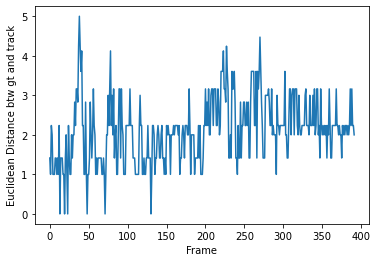

In [38]:
track_df = pd.DataFrame(track_list, columns = ["frame_no","center_x","center_y"])

if len(track_df) != 0:
    print("Tracking Method: ",tracker)
    print("Time: ",time_diff)
    print("Number of frame to track (gt): ", len(gt))
    print("Number of frame to track (track success): ",success_track_frame_success)
    
    track_df_frame = track_df.frame_no
    
    gt_center_x  = gt.center_x[track_df_frame].values
    gt_center_y = gt.center_y[track_df_frame].values
    
    track_df_center_x = track_df.center_x.values
    track_df_center_y = track_df.center_y.values
    
    plt.plot(np.sqrt((gt_center_x - track_df_center_x)**2 + (gt_center_y - track_df_center_y)**2 ))
    plt.xlabel("Frame")
    plt.ylabel("Euclidean Distance btw gt and track")
    error = np.sum(np.sqrt((gt_center_x - track_df_center_x)**2 + (gt_center_y - track_center_y)**2))
    print("Toplam Hata: ",error)
    